In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('names.txt', 'r').read().splitlines()
print(words[:10])
len(words)

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia', 'harper', 'evelyn']


32033

In [3]:
# characters mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [4]:
# build the dataset
block_size = 3 # how many characters do we take to predict the next one
X, Y = [], []

for w in words:
    # print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        # print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context [1:] + [ix] # crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)

In [5]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [6]:
C = torch.randn((27, 2)) # look up table
C[5]

tensor([ 0.0901, -0.5361])

In [7]:
embedding = C[X]
embedding.shape

torch.Size([228146, 3, 2])

In [8]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [9]:
h = torch.tanh(embedding.view(-1, 6) @ W1 + b1)
h

tensor([[ 0.9553, -0.9948,  0.0842,  ..., -0.9855, -0.9613, -0.9979],
        [ 0.9713, -0.9765, -0.8369,  ..., -0.8279, -0.6734, -0.9924],
        [ 0.8404, -0.2098, -0.0109,  ...,  0.3001,  0.8562, -0.8659],
        ...,
        [ 0.9138, -0.9481, -0.8422,  ..., -0.6680,  0.9148, -0.8921],
        [-0.7045, -0.8282,  1.0000,  ..., -0.9989,  0.7562, -0.8094],
        [ 0.9220, -1.0000,  0.9975,  ...,  0.8472,  0.9999, -0.9963]])

In [10]:
torch.cat([embedding[:, 0, :], embedding[:, 1, :], embedding[:, 2, :]], 1).shape

torch.Size([228146, 6])

In [11]:
torch.cat(torch.unbind(embedding, 1), 1).shape # unefficient - new tensor created

torch.Size([228146, 6])

In [12]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [13]:
logits = h @ W2 + b2

In [14]:
counts = logits.exp()

In [15]:
prob = counts / counts.sum(1, keepdim=True)

In [16]:
#------------------------------------------#

In [17]:
X.shape, Y.shape # Dataset

(torch.Size([228146, 3]), torch.Size([228146]))

In [39]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [40]:
sum(p.nelement() for p in parameters) # nr of parameters 

3481

In [41]:
for p in parameters:
    p.requires_grad = True

In [42]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10 ** lre

In [34]:
lri = []
lossi = []

for i in range(10000):
    #minibatch construct
    ix = torch.randint(0, X.shape[0], (32,))
    

    # forward pass
    emb = C[X[ix]] # shape : (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2 # shape : (32, 27)
    # counts = logits.exp()
    # prob = counts / counts.sum(1, keepdims=True)
    # loss = -prob[torch.arange(32), Y].log().mean()
    loss = F.cross_entropy(logits, Y[ix]) # does the same but more efficently
    
    # backward pass
    for p in parameters:
        p.grad = None 
    loss.backward()
    
    #update
    lr = 0.001
    for p in parameters:
        p.data += -lr * p.grad

    #track stats
    # lri.append(lre[i])
    # lossi.append(loss.item())

print(loss.item())

2.5491957664489746


In [35]:
emb = C[X]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y)
loss.item()

2.456348419189453

In [36]:
# training split, dev/validation split, test split
# 80%, 10%, 10%

In [35]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

print(sum(p.nelement() for p in parameters)) # nr of parameters 

for p in parameters:
    p.requires_grad = True

11897


In [36]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182512, 3]) torch.Size([182512])
torch.Size([22860, 3]) torch.Size([22860])
torch.Size([22774, 3]) torch.Size([22774])


In [37]:
stepi = []
lossi = []

In [44]:
for i in range(50000):
    
    #minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))
    

    # forward pass
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    
    # backward pass
    for p in parameters:
        p.grad = None 
    loss.backward()
    
    #update
    lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad

    stepi.append(i)
    lossi.append(loss.log10().item())

print(loss.item())

2.033778429031372


In [45]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss.item()

2.1927952766418457

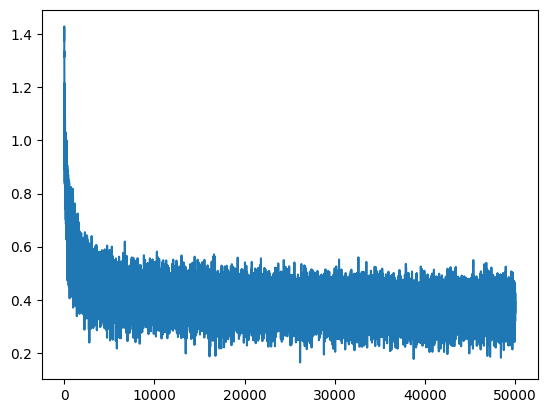

In [41]:
plt.plot(stepi, lossi)

In [52]:
# sample from the model

g = torch.Generator().manual_seed(214783647 + 2)

for _ in range(20):
    out = []
    context = [0] * block_size
    
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))

moa.
eman.
khancis.
jude.
nixi.
romont.
jaylarobi.
kyretha.
byson.
kari.
manton.
zaylah.
keer.
knon.
demoriali.
azonton.
emmory.
isza.
makidann.
clan.
